In [1]:
from keras.applications import VGG16

Using TensorFlow backend.


In [ ]:
#Feature extraction

In [2]:
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(150, 150, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [ ]:
#Extracting features using the pretrained convolutional base

In [4]:
import os 
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [5]:
base_dir = "C:/Users/Fizza Nazim/Desktop/Cats-and-Dogs3"
train_dir = os.path.join(base_dir , 'train')
validation_dir= os.path.join(base_dir , 'validation')
test_dir = os.path.join(base_dir , 'test')

In [6]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size=20

In [7]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [8]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
train_features = np.reshape(train_features, (2000, 4*4* 512))
validation_features = np.reshape(validation_features, (1000, 4*4* 512))
test_features = np.reshape(test_features, (1000, 4*4* 512))


#Defining and training the densely connected classifier


In [10]:
from keras import models
from keras import layers
from keras import optimizers

In [11]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu' , input_dim= 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer= optimizers.RMSprop(lr=2e-5),
             loss= 'binary_crossentropy',
             metrics=['acc'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
history= model.fit(train_features, train_labels, epochs=5, batch_size=20, validation_data=(validation_features , validation_labels))

Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/5
2000/2000 [==============================] - 7s 3ms/step - loss: 0.6188 - acc: 0.6645 - val_loss: 0.4618 - val_acc: 0.8090
Epoch 2/5
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4259 - acc: 0.8110 - val_loss: 0.3659 - val_acc: 0.8600
Epoch 3/5
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3654 - acc: 0.8360 - val_loss: 0.3243 - val_acc: 0.8750
Epoch 4/5
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3186 - acc: 0.8690 - val_loss: 0.2990 - val_acc: 0.8840
Epoch 5/5
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2883 - acc: 0.8810 - val_loss: 0.2926 - val_acc: 0.8720


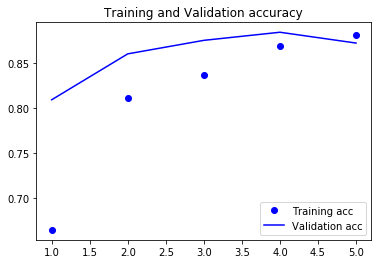

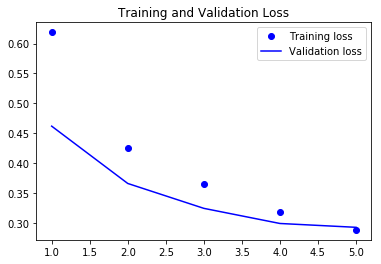

In [16]:
import matplotlib.pyplot as plt

acc= history.history['acc']
val_acc = history.history['val_acc']
loss= history.history['loss']
val_loss= history.history['val_loss']

epochs=range(1 , len(acc) + 1)

plt.plot(epochs , acc, 'bo' , label='Training acc')
plt.plot(epochs , val_acc , 'b' , label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss , 'bo' , label='Training loss')
plt.plot(epochs , val_loss , 'b' , label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()


In [14]:
#Adding a densely connected classifier on top of the convolutional base

In [17]:
from keras import models
from keras import layers

In [18]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [20]:
print('This is the number of trainable weights '
'before freezing the conv base:', len(model.trainable_weights))


This is the number of trainable weights before freezing the conv base: 30


In [21]:
conv_base.trainable = False
print('This is the number of trainable weights '
'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


#Training the model end to end with a frozen convolutional base

In [22]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [23]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [24]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [25]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [26]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [27]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=10,
                              epochs=3,
                              validation_data=validation_generator,
                              validation_steps=50)

Epoch 1/3
10/10 [==============================] - 479s 48s/step - loss: 0.7157 - acc: 0.5000 - val_loss: 0.6735 - val_acc: 0.5600
Epoch 2/3
10/10 [==============================] - 464s 46s/step - loss: 0.7011 - acc: 0.5000 - val_loss: 0.6280 - val_acc: 0.6730
Epoch 3/3
10/10 [==============================] - 464s 46s/step - loss: 0.6316 - acc: 0.6650 - val_loss: 0.6084 - val_acc: 0.6690


#FINE TUNNING

In [28]:
 conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [29]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
            layer.trainable = True
    else:
        layer.trainable = False

#Fine tunning the Model

In [30]:
model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-5),
metrics=['acc'])

In [31]:
history = model.fit_generator(
train_generator,
steps_per_epoch=10,
epochs=5,
validation_data=validation_generator,
validation_steps=50)

Epoch 1/5
10/10 [==============================] - 485s 49s/step - loss: 0.6163 - acc: 0.6800 - val_loss: 0.5402 - val_acc: 0.7460
Epoch 2/5
10/10 [==============================] - 475s 47s/step - loss: 0.5587 - acc: 0.7400 - val_loss: 0.5015 - val_acc: 0.8040
Epoch 3/5
10/10 [==============================] - 475s 47s/step - loss: 0.5311 - acc: 0.7950 - val_loss: 0.4410 - val_acc: 0.8370
Epoch 4/5
10/10 [==============================] - 484s 48s/step - loss: 0.4958 - acc: 0.7850 - val_loss: 0.4154 - val_acc: 0.8390
Epoch 5/5
10/10 [==============================] - 476s 48s/step - loss: 0.4470 - acc: 0.8150 - val_loss: 0.3922 - val_acc: 0.8480


#Smoothing the Plot


In [32]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

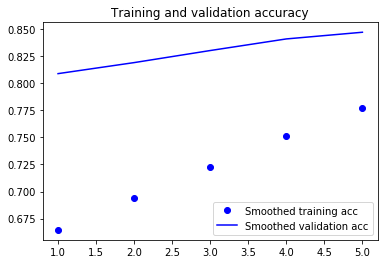

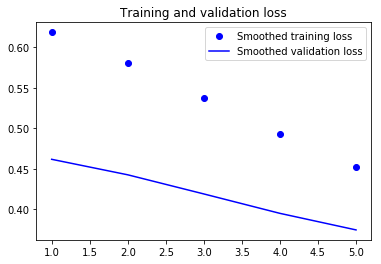

In [33]:
plt.plot(epochs,
         smooth_curve(acc),
         'bo',
         label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 
         'b', 
         label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss),
         'bo', 
         label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 
         'b',
         label='Smoothed validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [34]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150),
                                                  batch_size=20,
                                                  class_mode='binary')

Found 1000 images belonging to 2 classes.


In [35]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

test acc: 0.8410000014305115


In [36]:
print('test_loss' , test_loss)

test_loss 0.3926628467440605
